RECURRRENT NEURAL NETWORK
===

Imports
===

In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import time
import math
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [16]:
#validamos si tenemos GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print(device)

In [17]:
#USE DEVICE CPU
#device = torch.device('cpu')

Prepare Dataset
===

Shape de Train Tensor torch.Size([7266, 1])
Shape de Test Tensor torch.Size([1817, 1])


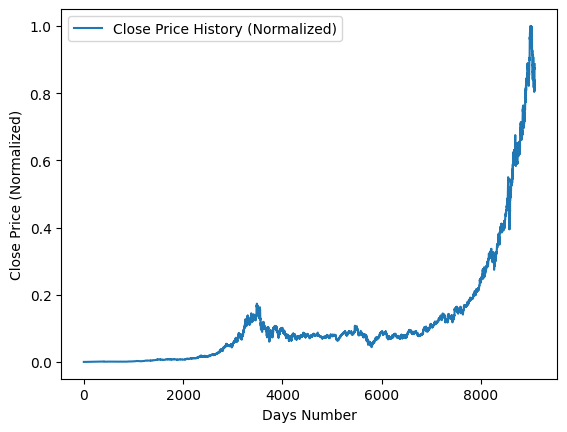

In [18]:
#Load data from csv and drop NaN
dataset = pd.read_csv('MSFT.csv')
dataset = dataset.dropna()

#only use close price for the prediction of the next price
dataset = dataset.iloc[:,4:5].values

#normalize data
sc = MinMaxScaler(feature_range = (0, 1))
dataset = sc.fit_transform(dataset)

#split into train and test, firts 80% for train, last 20% for test
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

#convert to tensor for batch processing
train_tensor = torch.FloatTensor(train)
test_tensor = torch.FloatTensor(test)

print('Shape de Train Tensor',train_tensor.shape)
print('Shape de Test Tensor',test_tensor.shape)

#plot data
plt.plot(dataset, label='Close Price History (Normalized)')
plt.legend()
plt.xlabel('Days Number')
plt.ylabel('Close Price (Normalized)')
plt.show()

RNN Model
===

In [19]:

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

#RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        #numero de capas ocultas
        self.hidden_size = hidden_size

        #----------define the recurrent layer, we have two options: 
        #self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size, bias=True)   #using a linear layer where the input is the concatenation of the input and hidden state to produce h_t= f(Wx_t + b + Uh_t-1 + b)
        self.in2hidden = nn.RNN(input_size, hidden_size)    #or using a RNN layer by pytorch where the input is the input and the hidden state to produce the same as above
        
        #define the hidden to output layer
        self.in2output = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden_state):
        #-----Use this if you are using a linear layer for the recurrent layer----
        #combined = torch.cat((x, hidden_state), 1)
        #hidden = torch.sigmoid(self.in2hidden(combined))
        #output = self.in2output(hidden)

        #-----Use this if you are using a RNN layer for the recurrent layer----
        output, hidden = self.in2hidden(x, hidden_state)
        # Reshaping the outputs such that it can be fit into the fully connected layer
        output = output.contiguous().view(-1, self.hidden_size)
        output = self.in2output(output)
        
        return output, hidden
    

    def init_hidden(self):
        '''
            This is used to initialize the hidden state with zeros when we start training
        '''
        #return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))
        return torch.zeros(1, self.hidden_size).to(device)
    


Trainig Functions
===

In [20]:
#trainig function for epoch
def train(input_tensor, criterion, optimizer,model,k,predict):
    hidden = model.init_hidden().to(device)    #at the beginning of each epoch we initialize the hidden state to zeros
    optimizer.zero_grad()
    loss = 0

    #-----if we are training----
    if predict==False:  
        for value in range(input_tensor.size(0)-1):   #for each value in batch
            target_tensor= input_tensor[value+1]    #the target is the next value
            output, hidden = model(input_tensor[value].unsqueeze(0) , hidden)   #we use the current value and the hidden state to predict the next value
            loss += criterion(output, target_tensor.unsqueeze(0))   #we calculate the loss, and accumulate it to use it later for the backpropagation

            #truncated backpropagation through time, used to save memory and speed up the training
            if (value +1)%k==0: #each k values we do the backpropagation and update the weights
                loss_para_return=loss.item() / k
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                hidden = hidden.detach()    #we detach the hidden state to avoid backpropagation through the entire sequence. The result will never require gradient.
                loss = 0    #we reset the loss to zero to start again with the next k values
    
    #-----if we are predicting----
    else:   
        lista_output=[] #we create a list to store the predictions
        for currentIterador in range (input_tensor.size(0)-k):  #to run over the entire sequence
            for value in range(currentIterador,currentIterador+k):  # to run k times to predict the next value, for example, if k=250 and want to predict the 501 value, we need to use the values from 251 to 500
                output, hidden = model(input_tensor[value].unsqueeze(0) , hidden)   #recurrent layer k times, to predict the k+1 value
            output_para_return=output.detach().cpu().numpy()  #the las output is the prediction, we detach it from the graph and convert it to numpy
            lista_output.append(output_para_return) #we append the prediction to the list 
            print("Predicting the value: ",currentIterador, end="\r")

        output=lista_output
        loss_para_return=0  #dont used because we are not training, but we need to return something
        
    return output, loss_para_return



#training function for the entire model
def trainEpoch(input_tensor, epochs, criterion, optimizer,model,k,predict=False):
    start = time.time() #to calculate the time of training
    print_every = 1 # Print every 1 epoch
    plot_every = 1  # for Plot every 1 epoch
    all_losses = [] 
    total_loss = 0 
    
    for epoch in range(1, epochs + 1):  #for each epoch
        output, loss = train(input_tensor, criterion, optimizer,model,k,predict)    #we train the model for one epoch
        total_loss += loss  #we accumulate the loss to plot it later, note that (from train function) is the last mean loss of the epoch
        if epoch % print_every == 0:    #print the loss and the time
            print('%s (%d %d%%) %.7f' % (timeSince(start), epoch, epoch / epochs * 100, loss))
        if epoch % plot_every == 0: #save the loss to plot it later
            all_losses.append(total_loss / plot_every)
            total_loss = 0
    return all_losses

Trainig the Model With the Market Data
===

In [22]:
#parameters
epochs = 10
hidden_size = 10    #number of hidden units
lr=0.04
input_size = 1  #we only use the close price to predict the next close price
output_size = 1 #we only predict the close price
k=250   #batch size o truncation length, it means that each k values we do the backpropagation and update the weights. Also, this is the number of values we use to predict the next value

# Define input tensors
input_tensor = train_tensor.to(device)    #we send the data to the GPU if we have one

# Initialize model using a seed for reproducibility
torch.manual_seed(5)
model= RNN(input_size, hidden_size, output_size)
model.to(device)    #we send the model to the GPU if we have one

# Define Loss, Optimizer
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()    #this work better than CrossEntropyLossm, i dont know why
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

all_losses = trainEpoch(input_tensor, epochs, criterion, optimizer,model,k,predict=False)


0m 5s (1 10%) 0.0058551
0m 10s (2 20%) 0.0073206
0m 15s (3 30%) 0.0066790
0m 19s (4 40%) 0.0039359
0m 24s (5 50%) 0.0014750
0m 29s (6 60%) 0.0001299
0m 34s (7 70%) 0.0000053
0m 38s (8 80%) 0.0000050
0m 43s (9 90%) 0.0000072
0m 48s (10 100%) 0.0000096


Loss Plot
===

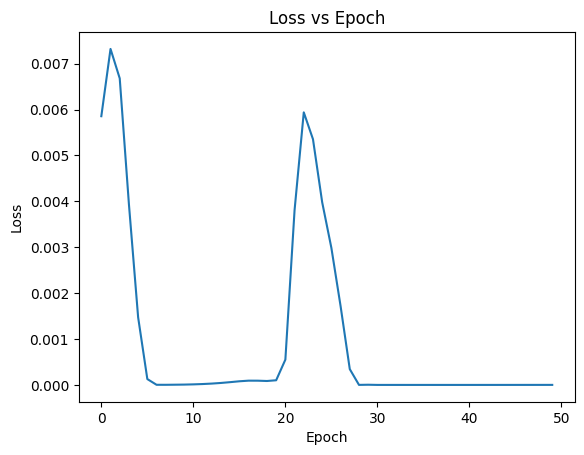

In [8]:
# Plot the losses vs epoch
plt.figure()
plt.plot(all_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()


Prediction over the same Training Data
===

In [9]:
#is to observe how the prediction adjust to train data
input_tensor = train_tensor 
output, loss = train(input_tensor, criterion, optimizer,model,k,predict=True)
output=np.array(output) #convert to numpy
output=output.reshape(-1,1) #this is because the output is a list of list, we need to convert it to a list of values to plot it

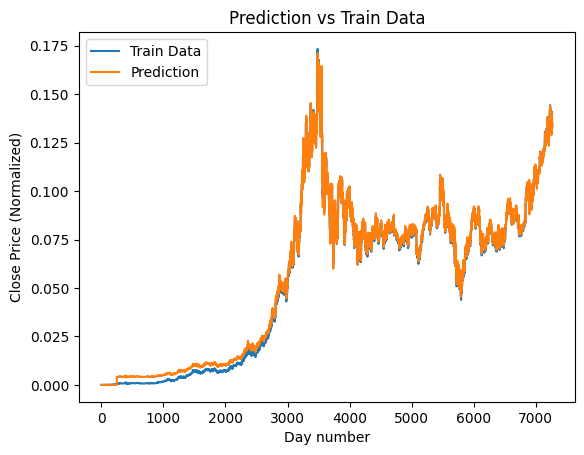

In [10]:
# Plot the prediction vs train data
output_1=np.concatenate((np.zeros((k,1)),output), axis=0)   #we add k zeros at the beginning to match the size of the train data
plt.plot(train_tensor)
plt.plot(output_1)
plt.xlabel('Day number')
plt.ylabel('Close Price (Normalized)')
plt.title('Prediction vs Train Data')
plt.legend(['Train Data', 'Prediction'], loc='upper left')
plt.show()

Close Up in Prediction vs Train Data Plot
======

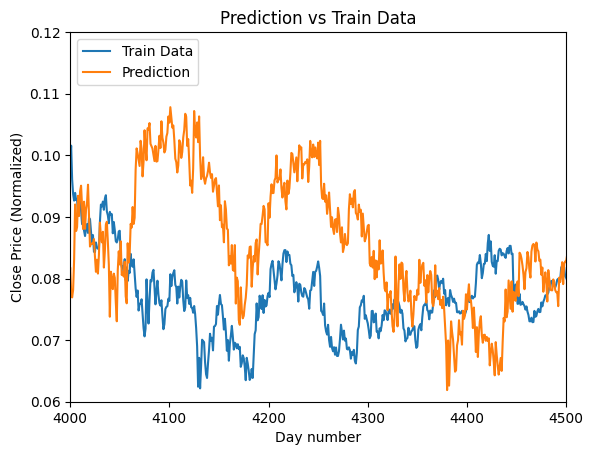

In [11]:
output_2=np.concatenate((np.zeros((500,1)),output), axis=0)
plt.plot(train_tensor)
plt.plot(output_2)
plt.axis([4000, 4500, 0.06, 0.12])
plt.xlabel('Day number')
plt.ylabel('Close Price (Normalized)')
plt.title('Prediction vs Train Data')
plt.legend(['Train Data', 'Prediction'], loc='upper left')
plt.show()

Prediction Using Testing Data
===

In [12]:
output_test, loss = train(test_tensor, criterion, optimizer,model,k,predict=True)
output_test=np.array(output_test)
output_test=output_test.reshape(-1,1)

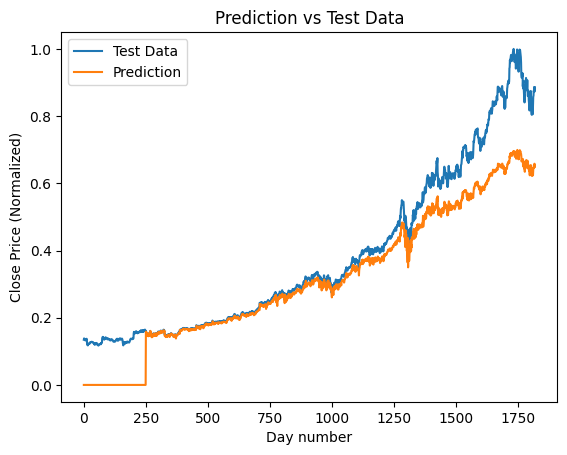

In [13]:
output_test_2=np.concatenate((np.zeros((250,1)),output_test), axis=0)
plt.plot(test_tensor)
plt.plot(output_test_2)
plt.xlabel('Day number')
plt.ylabel('Close Price (Normalized)')
plt.title('Prediction vs Test Data')
plt.legend(['Test Data', 'Prediction'], loc='upper left')
plt.show()